# IADH - DESAFIO 2 

# Versión Final

In [1]:
%autosave 600

Autosaving every 600 seconds


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import keras
print(keras.__version__)

/home/carlos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.2.0


# 1. PREPARACIÓN DE AMBIENTES

## Download de datos

In [4]:
BASE_DIR = '/home/carlos/DigitalHouse/desafio'
#BASE_DIR = 'C:/lab3'

In [5]:
os.chdir(BASE_DIR)

In [6]:
%%bash

if [ ! -f imdb_crop.tar ]; then
    wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
fi
if [ ! -d imdb_crop ]; then
    tar xf imdb_crop.tar
    echo "DATOS IMDB YA ESTAN DISPONIBLES" 
fi


if [ ! -f wiki_crop.tar ]; then
    wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
fi

if [ ! -d wiki_crop ]; then
    tar xf wiki_crop.tar
    echo "DATOS WIKI YA ESTAN DISPONIBLES"
fi


## Obtención de metadata de las imágenes

In [7]:
def get_metadata(mat_path, db='wiki'):
    meta = loadmat(mat_path)
    full_path = meta[db][0, 0]["full_path"][0]
    gender = meta[db][0, 0]["gender"][0]
    photo_taken = meta[db][0, 0]["photo_taken"][0]  # year
    face_score = meta[db][0, 0]["face_score"][0]
    second_face_score = meta[db][0, 0]["second_face_score"][0]
    df = pd.DataFrame(gender, columns=['gender'])
    df['face1'] = face_score
    df['face2'] = second_face_score
    df['path'] = [x[0] for x in full_path]
    df['nogender'] = np.where(df.gender.isna(), True, False)
    df['noface'] = np.where(df.face1 == -np.inf, True, False)
    df['manyfaces'] = np.where(df.face2.isna(), False, True)
    df['goodface'] = np.where(df.nogender | df.noface | df.manyfaces, False, True)
    df['hombre'] = df.gender == 1.0
    df['mujer'] = df.gender == 0.0
    return df

In [8]:
db = 'imdb'

In [9]:
path = BASE_DIR + "/" + db + "_crop/"+ db + ".mat"
print(path)
meta = get_metadata(path, db)
meta.shape
meta.head()

/home/carlos/DigitalHouse/desafio/imdb_crop/imdb.mat


,gender,face1,face2,path,nogender,noface,manyfaces,goodface,hombre,mujer
0,1.0,1.459693,1.118973,01/nm0000001_rm124825600_1899-5-10_1968.jpg,False,False,True,False,True,False
1,1.0,2.543198,1.852008,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,False,False,True,False,True,False
2,1.0,3.455579,2.985660,01/nm0000001_rm577153792_1899-5-10_1968.jpg,False,False,True,False,True,False
3,1.0,1.872117,NaN,01/nm0000001_rm946909184_1899-5-10_1968.jpg,False,False,False,True,True,False
4,1.0,1.158766,NaN,01/nm0000001_rm980463616_1899-5-10_1968.jpg,False,False,False,True,True,False


# TOMAR LOS DATOS DE MAYOR CALIDAD

In [10]:
meta2 = meta[meta.goodface].sort_values(by='face1', ascending=False)

In [11]:
meta2.head()

,gender,face1,face2,path,nogender,noface,manyfaces,goodface,hombre,mujer
69797,0.0,7.381689,NaN,72/nm0000572_rm3451099904_1965-3-25_2008.jpg,False,False,False,True,False,True
171089,0.0,7.196286,NaN,92/nm0005392_rm1126214912_1976-3-23_2013.jpg,False,False,False,True,False,True
29281,0.0,7.183938,NaN,04/nm0000204_rm1214421760_1981-6-9_1999.jpg,False,False,False,True,False,True
274825,1.0,7.169729,NaN,72/nm0134072_rm1979095808_1970-5-3_2007.jpg,False,False,False,True,True,False
24225,0.0,7.126821,NaN,82/nm0000182_rm1175359232_1969-7-24_2010.jpg,False,False,False,True,False,True


## Tamaño de muestras


In [12]:
NB_TRAIN, NB_VAL, NB_TEST = 20000, 10000, 10000

# Seleccion de datos de buena calidad

In [13]:
m =  meta2[meta2.hombre][:NB_TRAIN + NB_VAL + NB_TEST]
f =  meta2[meta2.mujer][:NB_TRAIN + NB_VAL + NB_TEST]
print(len(m), len(f))

40000 40000


In [14]:
mi = np.arange(len(m))
fi = np.arange(len(f))
np.random.shuffle(mi)
np.random.shuffle(fi)

## Armado de directorios

In [15]:
%%bash

rm -rf data2
mkdir -p data2/train/m
mkdir -p data2/train/f
mkdir -p data2/test/m
mkdir -p data2/test/f
mkdir -p data2/val/m
mkdir -p data2/val/f

In [16]:
DATA_DIR = BASE_DIR + '/data2'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')
for x in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(x)

/home/carlos/DigitalHouse/desafio/data2/train
/home/carlos/DigitalHouse/desafio/data2/val
/home/carlos/DigitalHouse/desafio/data2/test


In [17]:
SOURCE_DIR = BASE_DIR + '/' + db + '_crop/'
print(SOURCE_DIR)

/home/carlos/DigitalHouse/desafio/imdb_crop/


In [18]:
a, b, c = NB_TRAIN, NB_VAL, NB_TEST

In [19]:
for i in mi[0:a]: shutil.copy(SOURCE_DIR + m.path.iloc[i], TRAIN_DIR + '/m')
for i in mi[a:a+b]: shutil.copy(SOURCE_DIR + m.path.iloc[i], VAL_DIR + '/m')
for i in mi[a+b:a+b+c]: shutil.copy(SOURCE_DIR + m.path.iloc[i], TEST_DIR + '/m')

In [20]:
for i in fi[0:a]: shutil.copy(SOURCE_DIR + f.path.iloc[i], TRAIN_DIR + '/f')
for i in fi[a:a+b]: shutil.copy(SOURCE_DIR + f.path.iloc[i], VAL_DIR + '/f')
for i in fi[a+b:a+b+c]: shutil.copy(SOURCE_DIR + f.path.iloc[i], TEST_DIR + '/f')

In [21]:
for x in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for y in ['/f', '/m']:
        z = x + y
        print(len(os.listdir(z)), 'images in', z)

20000 images in /home/carlos/DigitalHouse/desafio/data2/train/f
20000 images in /home/carlos/DigitalHouse/desafio/data2/train/m
10000 images in /home/carlos/DigitalHouse/desafio/data2/val/f
10000 images in /home/carlos/DigitalHouse/desafio/data2/val/m
10000 images in /home/carlos/DigitalHouse/desafio/data2/test/f
10000 images in /home/carlos/DigitalHouse/desafio/data2/test/m


# Feature Extraction - VGG16

In [22]:
from keras.applications import  VGG16
conv_base = VGG16(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))

In [23]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)

In [24]:
batch_size = 20

In [25]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [26]:
train_features, train_labels = extract_features(TRAIN_DIR, NB_TRAIN)
validation_features, validation_labels = extract_features(VAL_DIR, NB_VAL)
test_features, test_labels = extract_features(TEST_DIR, NB_TEST)

Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [27]:
train_features = np.reshape(train_features, (NB_TRAIN, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (NB_VAL, 4 * 4 * 512))
test_features = np.reshape(test_features, (NB_TEST, 4 * 4 * 512))

In [28]:
from keras import models
from keras import layers
from keras import optimizers

In [29]:
def create_model_FE_VGG(neurons=256, dropout=0.0, bn=False):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim=4 * 4 * 512))
    
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
        
    if bn:
        model.add(layers.BatchNormalization())
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(
        optimizer = optimizers.RMSprop(lr=2e-5),
        loss = 'binary_crossentropy',
        metrics = ['acc'])
    return model

In [30]:
m1 = create_model_FE_VGG(256, 0.5)
m2 = create_model_FE_VGG(1024, 0.5, True )
m3 = create_model_FE_VGG(1024, 0.2, True )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________


In [31]:
m1_hist = m1.fit(train_features, train_labels,epochs=30, batch_size=20,
                 validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/30
20000/20000 [==============================] - 4s 223us/step - loss: 0.3418 - acc: 0.8555 - val_loss: 0.2441 - val_acc: 0.9099
Epoch 2/30
20000/20000 [==============================] - 3s 167us/step - loss: 0.2482 - acc: 0.9073 - val_loss: 0.2228 - val_acc: 0.9183
Epoch 3/30
20000/20000 [==============================] - 4s 178us/step - loss: 0.2279 - acc: 0.9158 - val_loss: 0.2133 - val_acc: 0.9206
Epoch 4/30
20000/20000 [==============================] - 3s 171us/step - loss: 0.2149 - acc: 0.9233 - val_loss: 0.2077 - val_acc: 0.9231
Epoch 5/30
20000/20000 [==============================] - 3s 161us/step - loss: 0.2086 - acc: 0.9252 - val_loss: 0.2048 - val_acc: 0.9242
Epoch 6/30
20000/20000 [==============================] - 4s 184us/step - loss: 0.2015 - acc: 0.9295 - val_loss: 0.2017 - val_acc: 0.9270
Epoch 7/30
20000/20000 [==============================] - 3s 174us/step - loss: 0.1968 - acc: 0.9317 - val_loss: 0.2033 - 

In [32]:
m2_hist = m2.fit(train_features, train_labels,epochs=10, batch_size=20,
                 validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 370us/step - loss: 0.3325 - acc: 0.8590 - val_loss: 0.2169 - val_acc: 0.9196
Epoch 2/10
20000/20000 [==============================] - 7s 351us/step - loss: 0.2586 - acc: 0.9019 - val_loss: 0.2067 - val_acc: 0.9252
Epoch 3/10
20000/20000 [==============================] - 7s 346us/step - loss: 0.2360 - acc: 0.9096 - val_loss: 0.1992 - val_acc: 0.9287
Epoch 4/10
20000/20000 [==============================] - 7s 347us/step - loss: 0.2195 - acc: 0.9180 - val_loss: 0.1973 - val_acc: 0.9319
Epoch 5/10
20000/20000 [==============================] - 7s 332us/step - loss: 0.2077 - acc: 0.9243 - val_loss: 0.1974 - val_acc: 0.9316
Epoch 6/10
20000/20000 [==============================] - 7s 357us/step - loss: 0.1988 - acc: 0.9285 - val_loss: 0.1967 - val_acc: 0.9300
Epoch 7/10
20000/20000 [==============================] - 7s 374us/step - loss: 0.1891 - acc: 0.9316 - val_loss: 0.1955 - 

In [33]:
m3_hist = m3.fit(train_features, train_labels,epochs=10, batch_size=20,
                 validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 337us/step - loss: 0.2976 - acc: 0.8820 - val_loss: 0.2115 - val_acc: 0.9243
Epoch 2/10
20000/20000 [==============================] - 7s 345us/step - loss: 0.2300 - acc: 0.9155 - val_loss: 0.2083 - val_acc: 0.9246
Epoch 3/10
20000/20000 [==============================] - 7s 340us/step - loss: 0.2046 - acc: 0.9247 - val_loss: 0.2004 - val_acc: 0.9293
Epoch 4/10
20000/20000 [==============================] - 6s 321us/step - loss: 0.1818 - acc: 0.9337 - val_loss: 0.2072 - val_acc: 0.9248
Epoch 5/10
20000/20000 [==============================] - 7s 343us/step - loss: 0.1659 - acc: 0.9400 - val_loss: 0.2074 - val_acc: 0.9260
Epoch 6/10
20000/20000 [==============================] - 7s 348us/step - loss: 0.1515 - acc: 0.9466 - val_loss: 0.2145 - val_acc: 0.9228
Epoch 7/10
20000/20000 [==============================] - 7s 364us/step - loss: 0.1458 - acc: 0.9482 - val_loss: 0.2023 - 

In [34]:
def plot_hist(hist, titulo=''):
    """
    Plots history of epochs accuracy and loss
    """
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(10,8))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.hlines(y=val_acc[-1], xmin=0, xmax=np.max(epochs), linewidth=2, color='r', linestyles='dotted')
    plt.title('ACCURACY ' + titulo)
    plt.legend()
    plt.figure(figsize=(10,8))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('LOSS ' + titulo)
    plt.legend()
    plt.show()
    return

In [35]:
loss1, acc1 = m1.evaluate(test_features, test_labels)
print("Model 1: Test Accuracy:", acc1)
loss2, acc2 = m2.evaluate(test_features, test_labels)
print("Model 2: Test Accuracy:", acc2)
loss3, acc3 = m3.evaluate(test_features, test_labels)
print("Model 3: Test Accuracy:", acc3)

10000/10000 [==============================] - 0s 44us/step
Model 1: Test Accuracy: 0.9303
10000/10000 [==============================] - 1s 51us/step
Model 2: Test Accuracy: 0.9328
10000/10000 [==============================] - 1s 51us/step
Model 3: Test Accuracy: 0.9248


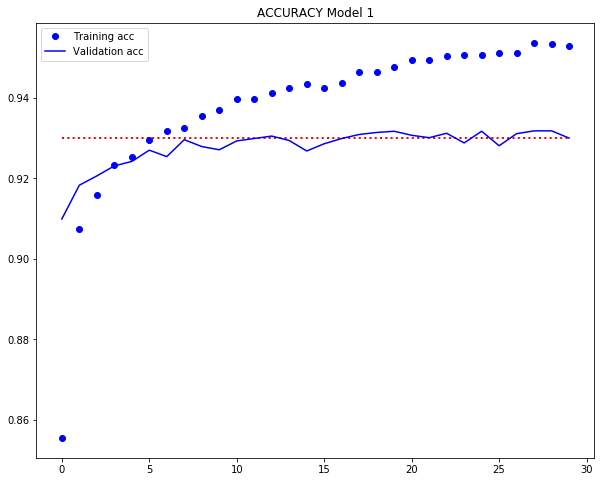

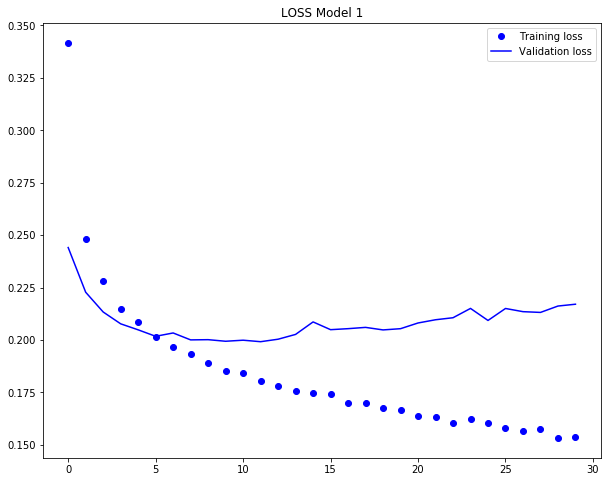

In [36]:
plot_hist(m1_hist, 'Model 1')

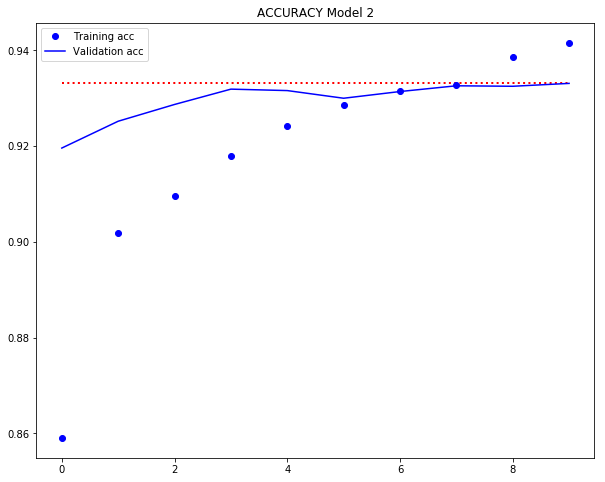

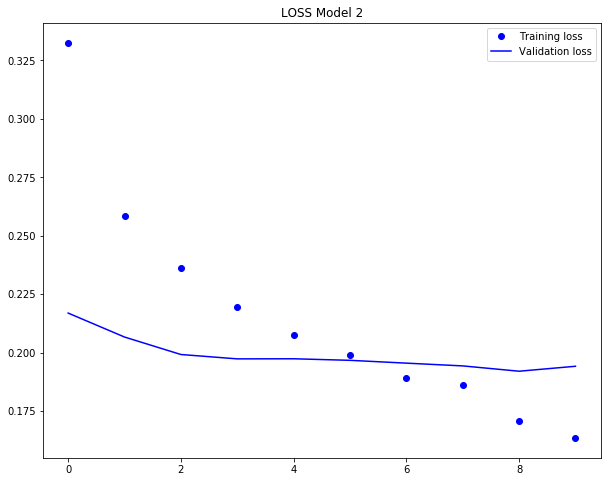

In [37]:
plot_hist(m2_hist, 'Model 2')

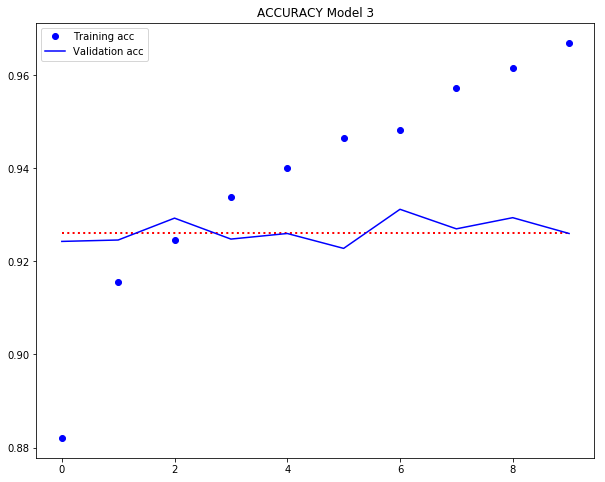

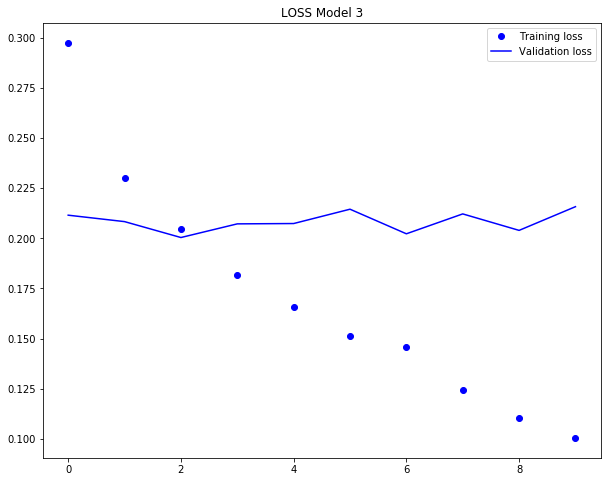

In [38]:
plot_hist(m3_hist, 'Model 3')

# Feature Extraction - InceptionV3

In [39]:
from keras.applications import InceptionV3
conv_base3 = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))

In [40]:
def extract_features_I3(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base3.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [41]:
train_features, train_labels = extract_features_I3(TRAIN_DIR, NB_TRAIN)
validation_features, validation_labels = extract_features_I3(VAL_DIR, NB_VAL)
test_features, test_labels = extract_features_I3(TEST_DIR, NB_TEST)
train_features = np.reshape(train_features, (NB_TRAIN, 3 * 3 * 2048))
validation_features = np.reshape(validation_features, (NB_VAL, 3 * 3 * 2048))
test_features = np.reshape(test_features, (NB_TEST, 3 * 3 * 2048))

Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [42]:
def create_model_FE_I3(neurons=256, dropout=0.5, bn=False):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim=3 * 3 * 2048))    
    if dropout >= 0.0:
        model.add(layers.Dropout(dropout))        
    if bn:
        model.add(layers.BatchNormalization())        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(
        optimizer = optimizers.RMSprop(lr=2e-5),
        loss = 'binary_crossentropy',
        metrics = ['acc'])
    return model

In [43]:
m4 = create_model_FE_I3()
m5 = create_model_FE_I3(1024)
m6 = create_model_FE_I3(1024, 0.2, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 4,719,105
Trainable params: 4,719,105
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________


In [44]:
m4_hist = m4.fit(train_features, train_labels, epochs=30, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/30
20000/20000 [==============================] - 8s 411us/step - loss: 0.2996 - acc: 0.8971 - val_loss: 0.2342 - val_acc: 0.9143
Epoch 2/30
20000/20000 [==============================] - 7s 365us/step - loss: 0.2410 - acc: 0.9189 - val_loss: 0.2374 - val_acc: 0.9177
Epoch 3/30
20000/20000 [==============================] - 7s 368us/step - loss: 0.2253 - acc: 0.9254 - val_loss: 0.2371 - val_acc: 0.9197
Epoch 4/30
20000/20000 [==============================] - 7s 370us/step - loss: 0.2065 - acc: 0.9297 - val_loss: 0.2444 - val_acc: 0.9199
Epoch 5/30
20000/20000 [==============================] - 8s 383us/step - loss: 0.1913 - acc: 0.9368 - val_loss: 0.2507 - val_acc: 0.9209
Epoch 6/30
20000/20000 [==============================] - 7s 356us/step - loss: 0.1812 - acc: 0.9403 - val_loss: 0.2440 - val_acc: 0.9242
Epoch 7/30
20000/20000 [==============================] - 7s 366us/step - loss: 0.1722 - acc: 0.9442 - val_loss: 0.2540 - 

In [45]:
m5_hist = m5.fit(train_features, train_labels, epochs=10, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 15s 736us/step - loss: 0.3275 - acc: 0.8984 - val_loss: 0.3145 - val_acc: 0.9026
Epoch 2/10
20000/20000 [==============================] - 14s 675us/step - loss: 0.2527 - acc: 0.9204 - val_loss: 0.2399 - val_acc: 0.9196
Epoch 3/10
20000/20000 [==============================] - 14s 706us/step - loss: 0.2325 - acc: 0.9269 - val_loss: 0.3254 - val_acc: 0.9060
Epoch 4/10
20000/20000 [==============================] - 14s 706us/step - loss: 0.2072 - acc: 0.9361 - val_loss: 0.2993 - val_acc: 0.9136
Epoch 5/10
20000/20000 [==============================] - 13s 660us/step - loss: 0.1892 - acc: 0.9415 - val_loss: 0.2623 - val_acc: 0.9210
Epoch 6/10
20000/20000 [==============================] - 14s 709us/step - loss: 0.1747 - acc: 0.9433 - val_loss: 0.2803 - val_acc: 0.9166
Epoch 7/10
20000/20000 [==============================] - 14s 701us/step - loss: 0.1620 - acc: 0.9471 - val_loss: 0.

In [46]:
m6_hist = m6.fit(train_features, train_labels, epochs=10, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 716us/step - loss: 0.2837 - acc: 0.8995 - val_loss: 0.2497 - val_acc: 0.9161
Epoch 2/10
20000/20000 [==============================] - 14s 716us/step - loss: 0.2154 - acc: 0.9245 - val_loss: 0.2696 - val_acc: 0.9075
Epoch 3/10
20000/20000 [==============================] - 15s 726us/step - loss: 0.1862 - acc: 0.9323 - val_loss: 0.2247 - val_acc: 0.9242
Epoch 4/10
20000/20000 [==============================] - 14s 697us/step - loss: 0.1633 - acc: 0.9417 - val_loss: 0.2247 - val_acc: 0.9246
Epoch 5/10
20000/20000 [==============================] - 14s 701us/step - loss: 0.1406 - acc: 0.9499 - val_loss: 0.2220 - val_acc: 0.9257
Epoch 6/10
20000/20000 [==============================] - 14s 723us/step - loss: 0.1248 - acc: 0.9563 - val_loss: 0.2366 - val_acc: 0.9239
Epoch 7/10
20000/20000 [==============================] - 13s 674us/step - loss: 0.1091 - acc: 0.9623 - val_loss: 0.

In [47]:
loss4, acc4 = m4.evaluate(test_features, test_labels)
print("Model 4: Test Accuracy:", acc4)
loss5, acc5 = m5.evaluate(test_features, test_labels)
print("Model 5: Test Accuracy:", acc5)
loss6, acc6 = m6.evaluate(test_features, test_labels)
print("Model 6: Test Accuracy:", acc6)

10000/10000 [==============================] - 1s 111us/step
Model 4: Test Accuracy: 0.9239
10000/10000 [==============================] - 1s 104us/step
Model 5: Test Accuracy: 0.9304
10000/10000 [==============================] - 1s 101us/step
Model 6: Test Accuracy: 0.9297


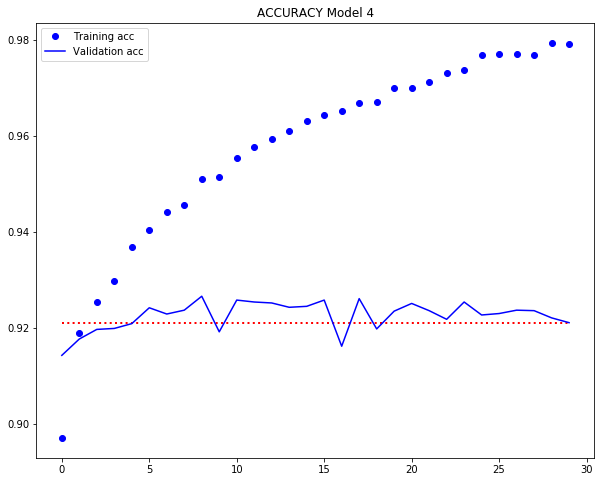

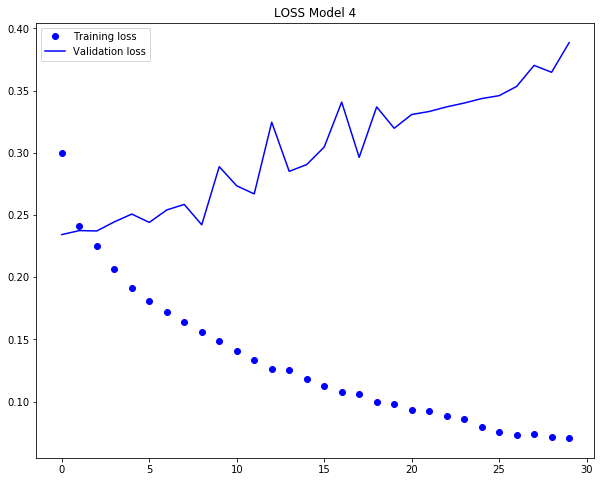

In [48]:
plot_hist(m4_hist, 'Model 4')

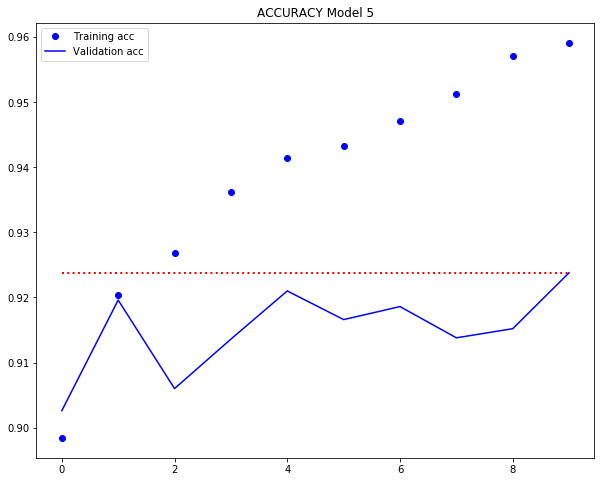

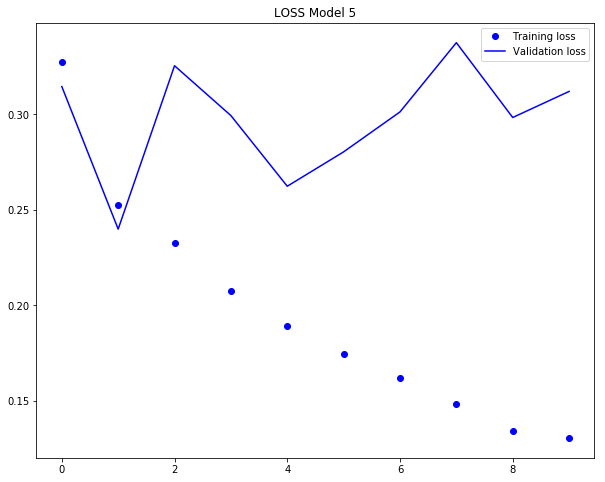

In [49]:
plot_hist(m5_hist, 'Model 5')

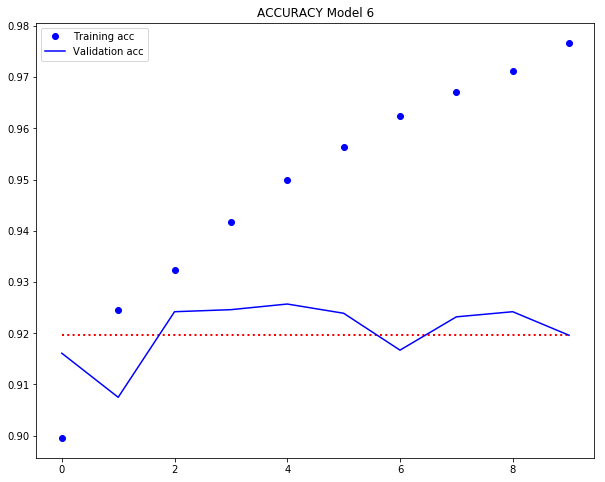

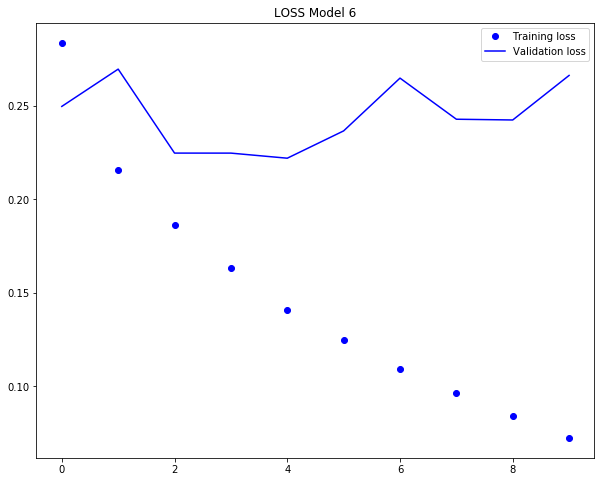

In [50]:
plot_hist(m6_hist, 'Model 6')

# Fine Tuning - VGG16

In [51]:
from keras.applications import  VGG16
conv_base_vgg16 = VGG16(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))

In [52]:
conv_base_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [53]:
conv_base_vgg16.trainable = True
set_trainable = False
for layer in conv_base_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
conv_base_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [55]:
def create_model_FT_VGG16(neurons=256, dropout=0.5, bn=False):
    model = models.Sequential()
    model.add(conv_base_vgg16)
    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='relu'))
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
    if bn:
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
    return model

In [56]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Notar que la data de validacion no debe ser aumentada!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

val_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [57]:
m7 = create_model_FT_VGG16()
m8 = create_model_FT_VGG16(1024)
m9 = create_model_FT_VGG16(1024, 0.5, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Pa

In [58]:
m9_hist = m9.fit_generator(
      train_generator,  epochs=30,   steps_per_epoch=100,
      validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/30
100/100 [==============================] - 10s 98ms/step - loss: 0.5110 - acc: 0.7410 - val_loss: 0.3266 - val_acc: 0.8690
Epoch 2/30
100/100 [==============================] - 9s 85ms/step - loss: 0.4238 - acc: 0.8260 - val_loss: 0.2539 - val_acc: 0.9080
Epoch 3/30
100/100 [==============================] - 9s 85ms/step - loss: 0.3265 - acc: 0.8640 - val_loss: 0.2131 - val_acc: 0.9090
Epoch 4/30
100/100 [==============================] - 9s 85ms/step - loss: 0.3442 - acc: 0.8615 - val_loss: 0.2204 - val_acc: 0.9120
Epoch 5/30
100/100 [==============================] - 9s 85ms/step - loss: 0.3351 - acc: 0.8695 - val_loss: 0.1944 - val_acc: 0.9260
Epoch 6/30
100/100 [==============================] - 9s 86ms/step - loss: 0.3089 - acc: 0.8850 - val_loss: 0.1771 - val_acc: 0.9240
Epoch 7/30
100/100 [==============================] - 9s 86ms/step - loss: 0.2903 - acc: 0.8780 - val_loss: 0.1775 - val_acc: 0.9350
Epoch 8/30
100/100 [==============================] - 8s 85ms/step -

In [59]:
loss9, acc9 = m9.evaluate_generator(test_generator, steps=100)
print('Model 9 - Test Accuracy:', acc9)

Model 9 - Test Accuracy: 0.918999993801117


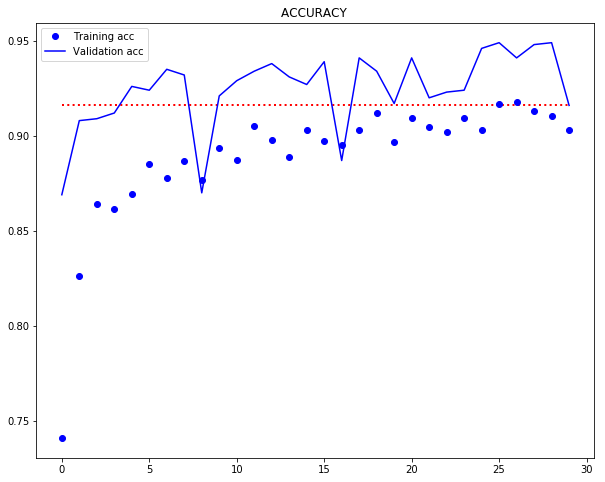

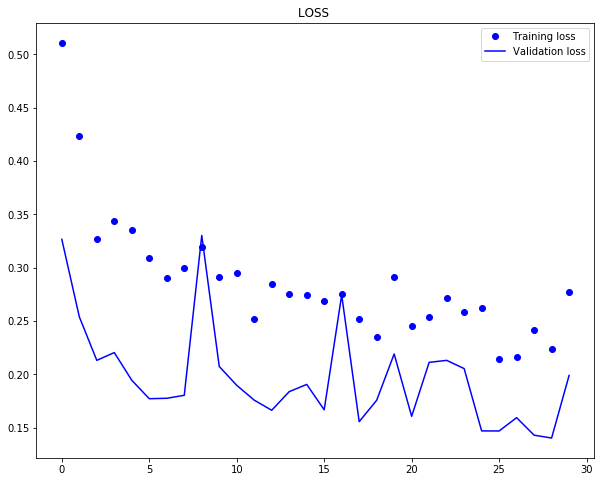

In [60]:
plot_hist(m9_hist)

# Feature Extraction - MobileNet

In [61]:
from keras.applications import MobileNet
conv_base_mob = MobileNet(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

In [62]:
datagen4 = ImageDataGenerator(rescale=1.0/255)

In [63]:
def extract_features_MOB(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))
    labels = np.zeros(shape=(sample_count))
    generator = datagen4.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_mob.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [64]:
train_features, train_labels = extract_features_MOB(TRAIN_DIR, NB_TRAIN)
validation_features, validation_labels = extract_features_MOB(VAL_DIR, NB_VAL)
test_features, test_labels = extract_features_MOB(TEST_DIR, NB_TEST)

Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [65]:
DIM_SIZE = 7 * 7 * 1024

In [66]:
train_features = np.reshape(train_features, (NB_TRAIN, DIM_SIZE))
validation_features = np.reshape(validation_features, (NB_VAL, DIM_SIZE))
test_features = np.reshape(test_features, (NB_TEST, DIM_SIZE))

In [67]:
def create_model_MOB(neurons=256, dropout=0.5, bn=False):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim=DIM_SIZE))
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
    if bn:
        model.add(layers.Batch_Normalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(
        optimizer = optimizers.RMSprop(lr=2e-5),
        loss = 'binary_crossentropy',
        metrics = ['acc'])
    return model

In [68]:
m10 = create_model_MOB()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               12845312  
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 12,845,569
Trainable params: 12,845,569
Non-trainable params: 0
_________________________________________________________________


In [69]:
m10_hist = m10.fit(train_features, train_labels,
                 epochs=10,
                 batch_size=20,
                 validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 15s 732us/step - loss: 0.2763 - acc: 0.9078 - val_loss: 0.2023 - val_acc: 0.9409
Epoch 2/10
20000/20000 [==============================] - 14s 707us/step - loss: 0.2061 - acc: 0.9419 - val_loss: 0.2198 - val_acc: 0.9420
Epoch 3/10
20000/20000 [==============================] - 14s 680us/step - loss: 0.1768 - acc: 0.9518 - val_loss: 0.2322 - val_acc: 0.9450
Epoch 4/10
20000/20000 [==============================] - 14s 679us/step - loss: 0.1564 - acc: 0.9585 - val_loss: 0.2397 - val_acc: 0.9460
Epoch 5/10
20000/20000 [==============================] - 14s 679us/step - loss: 0.1367 - acc: 0.9651 - val_loss: 0.2855 - val_acc: 0.9428
Epoch 6/10
20000/20000 [==============================] - 13s 669us/step - loss: 0.1261 - acc: 0.9681 - val_loss: 0.2823 - val_acc: 0.9434
Epoch 7/10
20000/20000 [==============================] - 14s 701us/step - loss: 0.1133 - acc: 0.9711 - val_loss: 0.

In [70]:
loss10, acc10 = m10.evaluate(test_features, test_labels)
print('Model 10 - Test Accuracy:', acc10)

10000/10000 [==============================] - 2s 182us/step
Model 10 - Test Accuracy: 0.9374


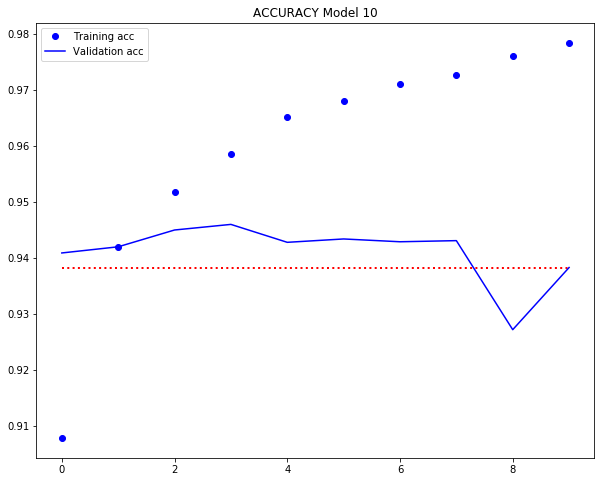

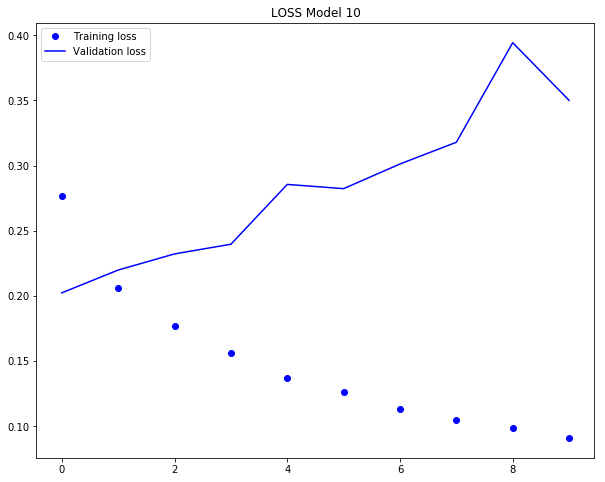

In [71]:
plot_hist(m10_hist, 'Model 10')